# 1. Histogram equalization

Give three test images with RAW format, 

please use the gamma correction you have developed in the last assignment 

to decrease/increase the brightness of the images.

In [65]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

In [66]:
imgDataF16 = np.fromfile('data/F16.raw', dtype='uint8')
imgDatalena = np.fromfile('data/lena.raw', dtype='uint8')
imgDataBaboon = np.fromfile('data/Baboon.raw', dtype='uint8')
imgDataflower = np.fromfile('data/flower.raw', dtype='uint8')

In [67]:
def raw_read(imgData):
    nr = 512
    nc = 512
    nchan = 1
    c = 0 #用 c來記錄 raw檔讀取到的 index位置
    img = np.zeros((nr, nc, nchan))
    for i in range(nr):
        for j in range(nc):
            for k in range(0, nchan):
                img[i, j, k] = imgData[c]
                c=c+1
    return img

In [68]:
img_F16 = raw_read(imgDataF16)
img_lena = raw_read(imgDatalena)
img_Baboon = raw_read(imgDataBaboon)
img_flower = raw_read(imgDataflower)

## degraded images

In [69]:
def ga(im, gamma, nchan):
    height = 512
    width = 512
    for row in range(height):
        for col in range(width):
            for chan in range(nchan):
                im[row][col][chan] = (int)(255*(im[row][col][chan] / 255) ** gamma)
    return im

In [70]:
gamma_F16 = ga(img_F16.copy(), 0.5, 1).astype('uint8').reshape(512,512)
gamma_lena = ga(img_lena.copy(), 0.5, 1).astype('uint8').reshape(512,512)
gamma_Baboon = ga(img_Baboon.copy(), 0.5, 1).astype('uint8').reshape(512,512)
gamma_flower = ga(img_flower.copy(), 0.5, 1).astype('uint8').reshape(512,512)

# i. global histogram equalization

In [71]:
def imhist(img):
  # calculates normalized histogram of an image
    m, n = img.shape
    h = [0.0] * 256
    for i in range(m):
        for j in range(n):
            h[img[i, j]]+=1
    return np.array(h)/(m*n)

In [72]:
def cumsum(h):
    # finds cumulative sum of a numpy array, list
    return [sum(h[:i+1]) for i in range(len(h))]

In [73]:
def histeq(im):
    #calculate Histogram
    h = imhist(im)
    #cumulative distribution function
    cdf = np.array(cumsum(h)) 
    #finding transfer function values
    sk = np.uint8(255 * cdf) 
    s1, s2 = im.shape
    Y = np.zeros_like(im)
    # applying transfered values for each pixels
    for i in range(0, s1):
        for j in range(0, s2):
            Y[i, j] = sk[im[i, j]]
    H = imhist(Y)
    #return transformed image, original and new histogram, and transform function
    return Y , h, H, sk

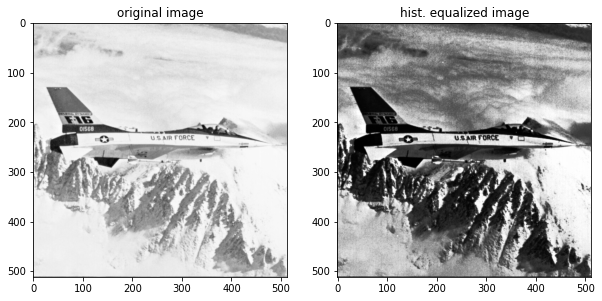

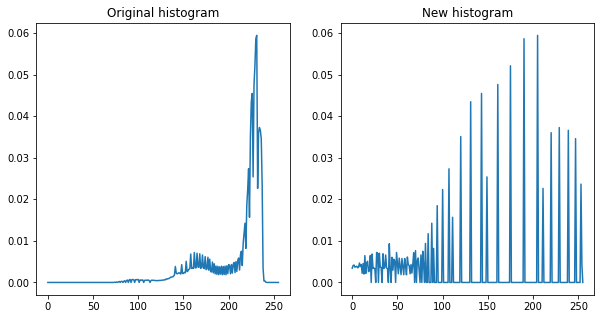

In [74]:
import pylab as plt
import matplotlib.image as mpimg
import numpy as np

new_img, h, new_h, sk = histeq(gamma_F16)

# show old and new image
f, axs = plt.subplots(1,2,figsize=(10,10))
plt.subplot(121)
plt.imshow(img)
plt.title('original image')
plt.set_cmap('gray')
plt.subplot(122)
plt.imshow(new_img)
plt.title('hist. equalized image')
plt.set_cmap('gray')
plt.show()

# plot histograms and transfer function
f, axs = plt.subplots(1,2,figsize=(10,5))
plt.subplot(121)
plt.plot(h)
plt.title('Original histogram')
plt.subplot(122)
plt.plot(new_h)
plt.title('New histogram')

plt.show()

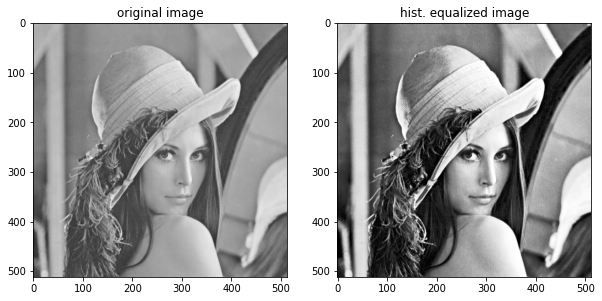

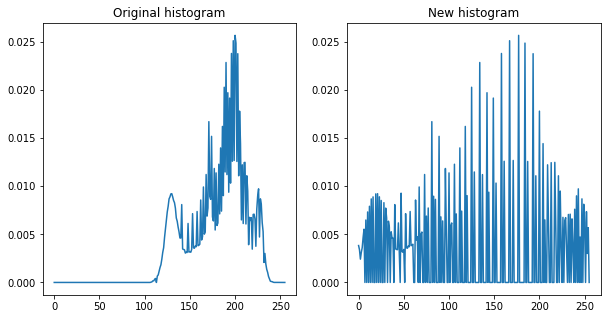

In [75]:
import pylab as plt
import matplotlib.image as mpimg
import numpy as np

new_img, h, new_h, sk = histeq(gamma_lena)

# show old and new image
f, axs = plt.subplots(1,2,figsize=(10,10))
plt.subplot(121)
plt.imshow(img_lena)
plt.title('original image')
plt.set_cmap('gray')
plt.subplot(122)
plt.imshow(new_img)
plt.title('hist. equalized image')
plt.set_cmap('gray')
plt.show()

# plot histograms and transfer function
f, axs = plt.subplots(1,2,figsize=(10,5))
plt.subplot(121)
plt.plot(h)
plt.title('Original histogram')
plt.subplot(122)
plt.plot(new_h)
plt.title('New histogram')

plt.show()

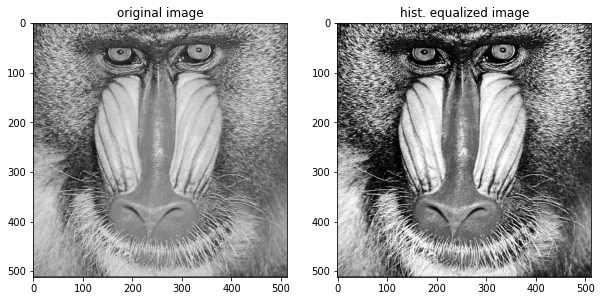

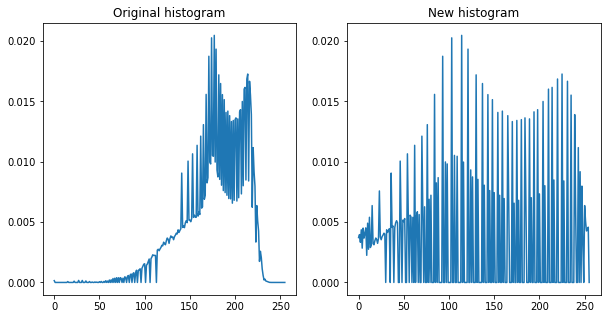

In [76]:
import pylab as plt
import matplotlib.image as mpimg
import numpy as np

new_img, h, new_h, sk = histeq(gamma_Baboon)

# show old and new image
f, axs = plt.subplots(1,2,figsize=(10,10))
plt.subplot(121)
plt.imshow(img_Baboon)
plt.title('original image')
plt.set_cmap('gray')
plt.subplot(122)
plt.imshow(new_img)
plt.title('hist. equalized image')
plt.set_cmap('gray')
plt.show()

# plot histograms and transfer function
f, axs = plt.subplots(1,2,figsize=(10,5))
plt.subplot(121)
plt.plot(h)
plt.title('Original histogram')
plt.subplot(122)
plt.plot(new_h)
plt.title('New histogram')

plt.show()

# ii. local histogram equalization

In [77]:
def addpadding(source,ksize):
    pad = ksize//2
    imarr = np.array(source)
    padimarr = np.zeros((imarr.shape[0]+2*pad,imarr.shape[1]+2*pad),dtype=np.uint8)
    padimarr[pad:padimarr.shape[0]-pad,pad:padimarr.shape[1]-pad]=imarr
    return padimarr

In [78]:
def part(local, ksize): #local hist. eq. function
    possibility = [0 for i in range (256)] # need for local hist. eq.
    for v in range (ksize):
        for h in  range (ksize):
            P= local [v] [h]
            possibility[P] = possibility[P] +1

    for o in range (256):
        possibility[o] = float(float ( float ( possibility[o]) / (ksize**2) ) * 255 )
        possibility[o] = int (round( possibility[o]))
        
    S = local [ksize//2][ksize//2]
    
    return possibility[S]

In [79]:
def local_hist3(orimg, ksize):
    pad = ksize//2
    img = addpadding(orimg,ksize)
    Matrix = [[0 for x in range(512+2*pad)] for y in range(512+2*pad)] 

    for i in range(512): 
        for y in range(512):
            temp1 = np.array([img[i, y], img[i+1, y], img[i+2, y]])
            local = np.vstack([temp1])
            temp2 = np.array([img[i, y+1], img[i+1, y+1], img[i+2, y+1]])
            local = np.vstack([local, temp2])
            temp3 = np.array([img[i, y + 2], img[i + 1, y + 2], img[i + 2, y + 2]])
            local = np.vstack([local, temp3])
            Matrix[i+1][y+1]=part(local, ksize)

    
    # again convert orjinal size"example 512 x 512 image"
    MatrixFinish = [[0 for x in range(512)] for y in range(512)]
    for k in range (512):
        for t in range(512):
            MatrixFinish[t][k] =  Matrix[t+1][k+1]

    return MatrixFinish

In [80]:
def local_hist5(orimg, ksize):
    pad = ksize//2
    img = addpadding(orimg,ksize)
    Matrix = [[0 for x in range(512+2*pad)] for y in range(512+2*pad)] 

    for i in range(512): 
        for y in range(512):
            temp1 = np.array([img[i, y], img[i+1, y], img[i+2, y], img[i+3, y], img[i+4, y]])
            local = np.vstack([temp1])
            temp2 = np.array([img[i, y+1], img[i+1, y+1], img[i+2, y+1], img[i+3, y+1], img[i+4, y+1]])
            local = np.vstack([local, temp2])
            temp3 = np.array([img[i, y + 2], img[i + 1, y + 2], img[i + 2, y + 2], img[i + 3, y + 2], img[i + 4, y + 2]])
            local = np.vstack([local, temp3])
            temp4 = np.array([img[i, y+3], img[i+1, y+3], img[i+2, y+3], img[i + 3, y + 3], img[i + 4, y + 3]])
            local = np.vstack([local, temp4])
            temp5 = np.array([img[i, y+4], img[i+1, y+4], img[i+2, y+4], img[i + 3, y + 4], img[i + 4, y + 4]])
            local = np.vstack([local, temp5])

            Matrix[i+pad][y+pad]=part(local, ksize)

    
    # again convert orjinal size"example 512 x 512 image"
    MatrixFinish = [[0 for x in range(512)] for y in range(512)]
    for k in range (512):
        for t in range(512):
            MatrixFinish[t][k] =  Matrix[t+pad][k+pad]

    return MatrixFinish

In [81]:
def local_hist7(orimg, ksize):
    pad = ksize//2
    img = addpadding(orimg,ksize)
    Matrix = [[0 for x in range(512+2*pad)] for y in range(512+2*pad)] 

    for i in range(512): 
        for y in range(512):
            temp1 = np.array([img[i, y], img[i+1, y], img[i+2, y], img[i+3, y], img[i+4, y], img[i+5, y], img[i+6, y]])
            local = np.vstack([temp1])
            temp2 = np.array([img[i, y+1], img[i+1, y+1], img[i+2, y+1], img[i+3, y+1], img[i+4, y+1], img[i+5, y+1], img[i+6, y+1]])
            local = np.vstack([local, temp2])
            temp3 = np.array([img[i, y+2], img[i+1, y+2], img[i+2, y+2], img[i+3, y+2], img[i+4, y+2], img[i+5, y+2], img[i+6, y+2]])
            local = np.vstack([local, temp3])
            temp4 = np.array([img[i, y+3], img[i+1, y+3], img[i+2, y+3], img[i+3, y+3], img[i+4, y+3], img[i+5, y+3], img[i+6, y+3]])
            local = np.vstack([local, temp4])
            temp5 = np.array([img[i, y+4], img[i+1, y+4], img[i+2, y+4], img[i+3, y+4], img[i+4, y+4], img[i+5, y+4], img[i+6, y+4]])
            local = np.vstack([local, temp5])
            temp6 = np.array([img[i, y+5], img[i+1, y+5], img[i+2, y+5], img[i+3, y + 5], img[i+4, y + 5], img[i+5, y + 5], img[i+6, y + 5]])
            local = np.vstack([local, temp5])
            temp7 = np.array([img[i, y+6], img[i+1, y+6], img[i+2, y+6], img[i+3, y + 6], img[i+4, y + 6], img[i+5, y + 6], img[i+6, y + 6]])
            local = np.vstack([local, temp5])

            Matrix[i+pad][y+pad]=part(local, ksize)

    
    # again convert orjinal size"example 512 x 512 image"
    MatrixFinish = [[0 for x in range(512)] for y in range(512)]
    for k in range (512):
        for t in range(512):
            MatrixFinish[t][k] =  Matrix[t+pad][k+pad]

    return MatrixFinish

F16

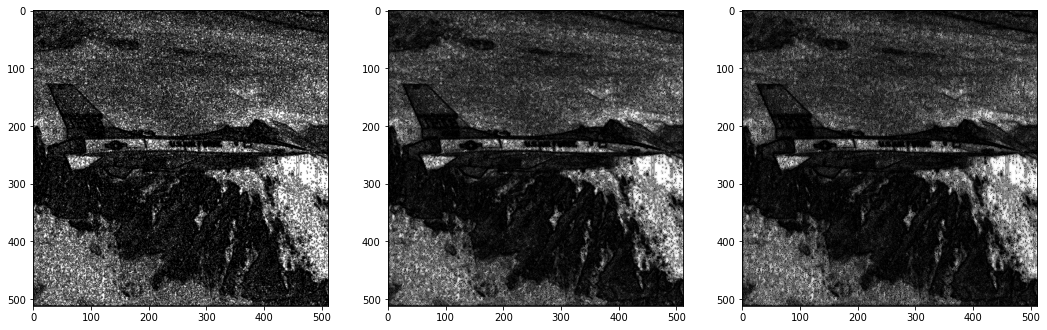

In [82]:
img_lochist_F16_3 = local_hist3(gamma_F16.copy(), 3)
img_lochist_F16_5 = local_hist5(gamma_F16.copy(), 5)
img_lochist_F16_7 = local_hist7(gamma_F16.copy(), 7)

images = [img_lochist_F16_3, img_lochist_F16_5, img_lochist_F16_7]
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 18))
for ind, p in enumerate(images):
    ax = axs[ind]
    ax.imshow(p, cmap='gray')
plt.show()

lena

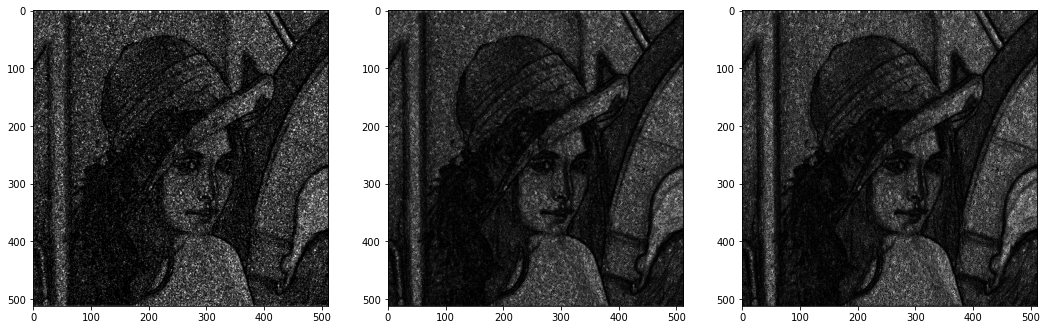

In [83]:
img_lochist_lena_3 = local_hist3(gamma_lena.copy().reshape(512,512), 3)
img_lochist_lena_5 = local_hist5(gamma_lena.copy().reshape(512,512), 5)
img_lochist_lena_7 = local_hist7(gamma_lena.copy().reshape(512,512), 7)

images = [img_lochist_lena_3, img_lochist_lena_5, img_lochist_lena_7]
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 18))
for ind, p in enumerate(images):
    ax = axs[ind]
    ax.imshow(p, cmap='gray')
plt.show()

Baboon

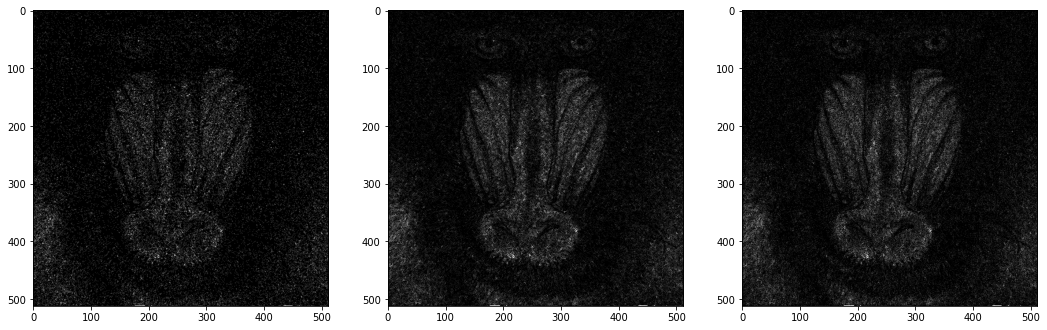

In [84]:
img_lochist_Baboon_3 = local_hist3(gamma_Baboon.copy().reshape(512,512), 3)
img_lochist_Baboon_5 = local_hist5(gamma_Baboon.copy().reshape(512,512), 5)
img_lochist_Baboon_7 = local_hist7(gamma_Baboon.copy().reshape(512,512), 7)

images = [img_lochist_Baboon_3, img_lochist_Baboon_5, img_lochist_Baboon_7]
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 18))
for ind, p in enumerate(images):
    ax = axs[ind]
    ax.imshow(p, cmap='gray')
plt.show()

# iii. Histogram matching: 

Flower

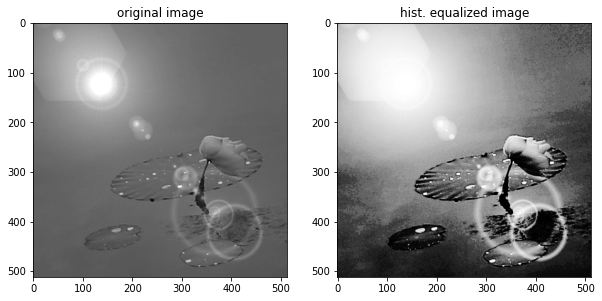

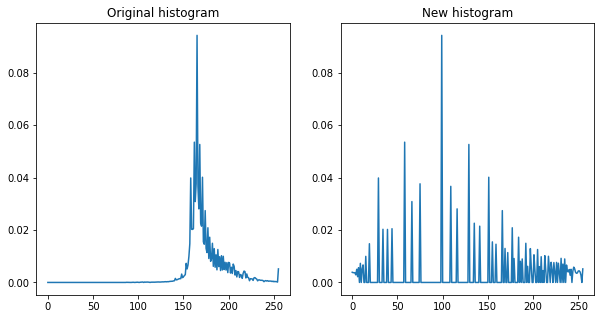

In [85]:
import pylab as plt
import matplotlib.image as mpimg
import numpy as np

new_img, h, new_h, sk = histeq(gamma_flower)

# show old and new image
f, axs = plt.subplots(1,2,figsize=(10,10))
plt.subplot(121)
plt.imshow(img_flower)
plt.title('original image')
plt.set_cmap('gray')
plt.subplot(122)
plt.imshow(new_img)
plt.title('hist. equalized image')
plt.set_cmap('gray')
plt.show()

# plot histograms and transfer function
f, axs = plt.subplots(1,2,figsize=(10,5))
plt.subplot(121)
plt.plot(h)
plt.title('Original histogram')
plt.subplot(122)
plt.plot(new_h)
plt.title('New histogram')

plt.show()

map F16

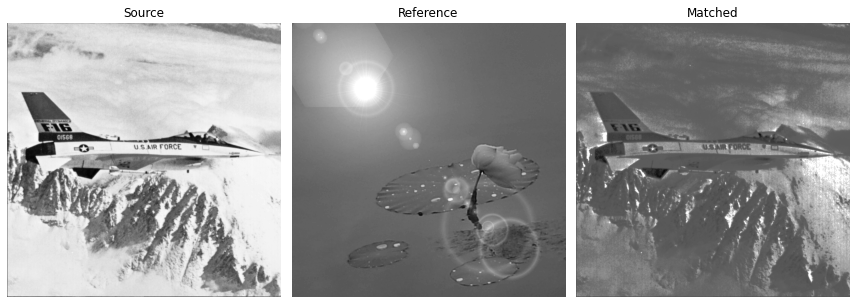

In [86]:
import matplotlib.pyplot as plt

#from skimage import data
from skimage import exposure
from skimage.exposure import match_histograms

matched_F16 = match_histograms(img_F16, img_flower)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 12),
                                    sharex=True, sharey=True)
for aa in (ax1, ax2, ax3):
    aa.set_axis_off()

ax1.imshow(img_F16, cmap='gray')
ax1.set_title('Source')
ax2.imshow(img_flower, cmap='gray')
ax2.set_title('Reference')
ax3.imshow(matched_F16, cmap='gray')
ax3.set_title('Matched')

plt.tight_layout()
plt.show()

map lena

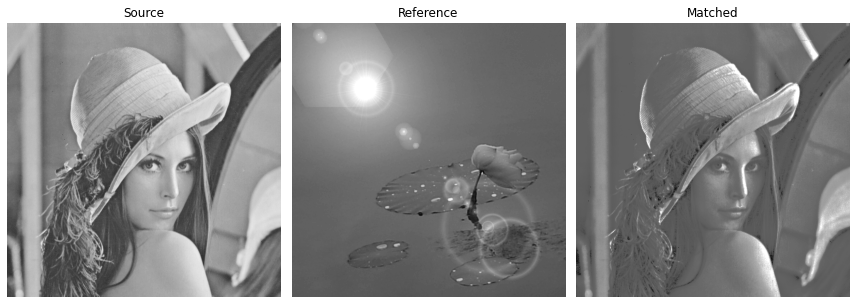

In [87]:
import matplotlib.pyplot as plt

from skimage import data
from skimage import exposure
from skimage.exposure import match_histograms

matched_lena = match_histograms(img_lena, img_flower)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 12),
                                    sharex=True, sharey=True)
for aa in (ax1, ax2, ax3):
    aa.set_axis_off()

ax1.imshow(img_lena, cmap='gray')
ax1.set_title('Source')
ax2.imshow(img_flower, cmap='gray')
ax2.set_title('Reference')
ax3.imshow(matched_lena, cmap='gray')
ax3.set_title('Matched')

plt.tight_layout()
plt.show()

map Baboon

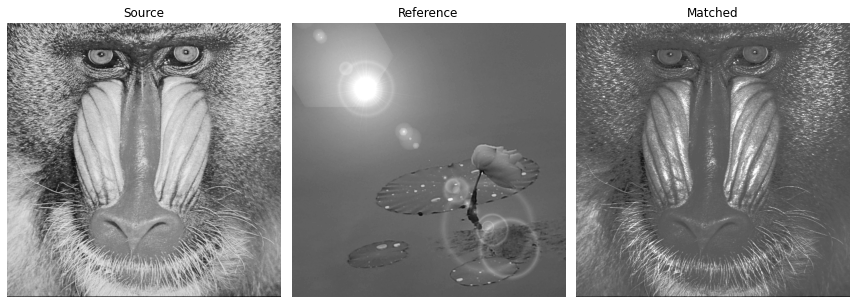

In [88]:
matched_Baboon = match_histograms(img_Baboon, img_flower)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 12),
                                    sharex=True, sharey=True)
for aa in (ax1, ax2, ax3):
    aa.set_axis_off()

ax1.imshow(img_Baboon, cmap='gray')
ax1.set_title('Source')
ax2.imshow(img_flower, cmap='gray')
ax2.set_title('Reference')
ax3.imshow(matched_Baboon, cmap='gray')
ax3.set_title('Matched')

plt.tight_layout()
plt.show()